In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as tfs
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from torchvision import models
from IPython.display import clear_output

import pandas as pd

from __future__ import print_function, division
import os

from skimage import io, transform
from tqdm import tqdm_notebook
from tqdm.notebook import tqdm
from tqdm.autonotebook import trange
import pickle
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
from multiprocessing.pool import ThreadPool
import time
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.2)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu') 
device

device(type='cuda', index=0)



# Autoencoders. Часть 1



В этом ноутбуке мы сконструируем простой автоэнкодер и применим его для решения задачи детекции аномалий во временных рядах.

Напоминаем, что автоэнкодер имеет следующий вид:
![](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

Наша идея заключается в следующем: поскольку автоэнкодер выучивает распределение элементов обучающей выборки, он будет хорошо справляться с реконструкцией более вероятных объектов (т. е. тех, которые не являются аномалиями). Если же в тестовой выборке есть аномалия, то кодировщик реконструирует ее плохо, т. е. мы будем иметь большой лосс. Следовательно, будем считать аномалиями те объекты, лосс которых выше некоторого порога.

## Загрузка данных

Мы будем использовать датасет [Numenta Anomaly Benchmark(NAB)](
https://www.kaggle.com/boltzmannbrain/nab) Это искусственно сгенерированный временной ряд с двумя признаками – `timestamp` и `value`

Для обучения мы возьмем файл `art_daily_small_noise.csv` (данные с маленьким шумом, без аномалий), а для теста возьмем
`art_daily_jumpsup.csv` (зашумленный, с аномалиями)

In [3]:
# set global link
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"


# set full path
df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix


# read and download the data
df_small_noise = pd.read_csv(df_small_noise_url, parse_dates=True, index_col="timestamp")
df_daily_jumpsup = pd.read_csv(df_daily_jumpsup_url, parse_dates=True, index_col="timestamp")

In [5]:
df_small_noise.head()
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


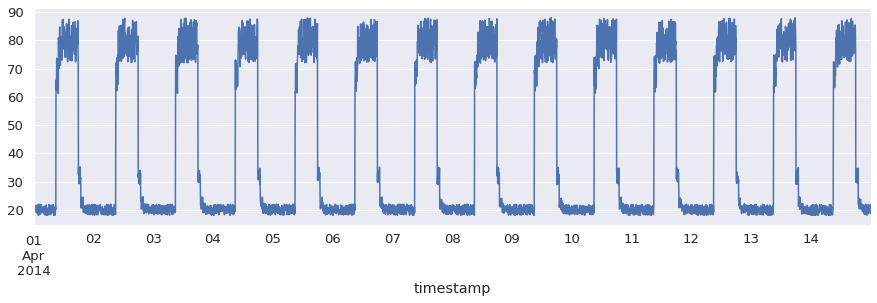

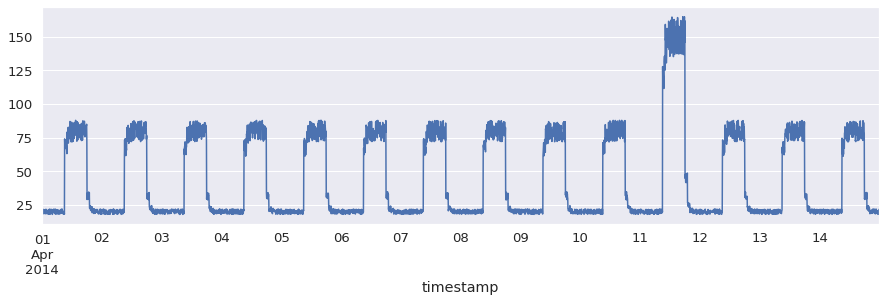

In [6]:
fig, ax = plt.subplots(figsize=(15, 4))
df_small_noise.plot(legend=False, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(15, 4))
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

##  Обработка данных

Нормализуем значения признака
`value`. У нас есть `value` для 14 дней с периодичностью 5 минут

-   24 * 60 / 5 = **288 timesteps per day**
-   288 * 14 = **4032 data points** in total

Сгенерируем последовательности длительностью в 1 день **(288 time steps)**, а также разделим выборку на train и val:

In [7]:
# =============================================
# ============ 0) Prepare the data ============
# =============================================

# normilize and same the mean and std:
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std


TIME_STEPS = 288

# genereate trainig sequences (последовательности) for use in the model:
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i: (i+time_steps)])
    return torch.FloatTensor(output).permute(0, 2, 1)
    # PyTorch torch.permute() rearranges the original tensor according to the
    # desired ordering and returns a new multidimensional rotated tensor. 
    # The size of the returned tensor remains the same as that of the original.

X = create_sequences(df_training_value.values)
x_train, x_val = train_test_split(X, test_size = 0.9, shuffle = False)
# when we work with time dependent data we do NOT mixing the data -> shuffle=False
print("Training shape = ", x_train.shape)

train_loader = DataLoader(x_train, batch_size=4)
val_loader = DataLoader(x_val, batch_size=4)



Training shape =  torch.Size([374, 1, 288])


<ipython-input-7-e0c61ecafd01>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.FloatTensor(output).permute(0, 2, 1)


## Построение модели

Мы будем строить сверточный автоэнкодер, принимающий на вход тензор размерности `(batch_size, sequence_length, num_features)` и возвращающий тензор такой же размерности. В нашем случае `sequence_length = 288` и
`num_features = 1`.

In [24]:
from pandas.core.aggregation import reconstruct_func
# =============================================
# =========== 1) Model preparation ============
# =============================================


class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # the latent representation
        self.encoder = nn.Sequential(
                       nn.Conv1d(1, 32, kernel_size=7, stride=1, padding=3),
                       nn.ReLU(),
                       nn.Conv1d(32, 16, kernel_size=7, stride=1, padding=3),
                       nn.ReLU(),
                       )
        self.decoder = nn.Sequential(
                       nn.ConvTranspose1d(16, 16, kernel_size=7, stride=1, padding=3),
                       nn.ReLU(),
                       nn.ConvTranspose1d(16, 32, kernel_size=7, stride=1, padding=3),
                       nn.ReLU(),
                       nn.ConvTranspose1d(32, 1, kernel_size=7, stride=1, padding=3),              
                      )
    def forward(self, x):
        latent_layer = self.encoder(x)
        reconstucted = self.decoder(latent_layer)
        return reconstucted


## Обучение

Заметим, что поскольку мы занимаемся реконструкцией, train/val у нас выступает как в роли входа для сети, так и в роли таргета

In [27]:

# =============================================
# =========== 1) Trainig loop =================
# =============================================

n_epochs = 50

# set model, optimizer and losss
model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = F.mse_loss

trainig_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    train_loss_per_epoch = []
    for i, x_batch in enumerate(train_loader):
        x_batch = x_batch.to(device)
        optimizer.zero_grad()

        # forward pass: predicted and loss
        reconstructed = model(x_batch)
        loss = loss_fn(reconstructed, x_batch)

        # backward pass
        loss.backward()
        optimizer.step()
        train_loss_per_epoch.append(loss.item())
    trainig_losses.append(np.mean(train_loss_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for x_batch in val_loader:
            x_batch = x_batch.to(device)
            reconstructed = model(x_batch)
            loss = loss_fn(reconstructed, x_batch)
            val_losses_per_epoch.append(loss.item())
    val_losses.append(np.mean(val_losses_per_epoch))





<ipython-input-27-3b25c3bda704>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/50 [00:00<?, ?it/s]

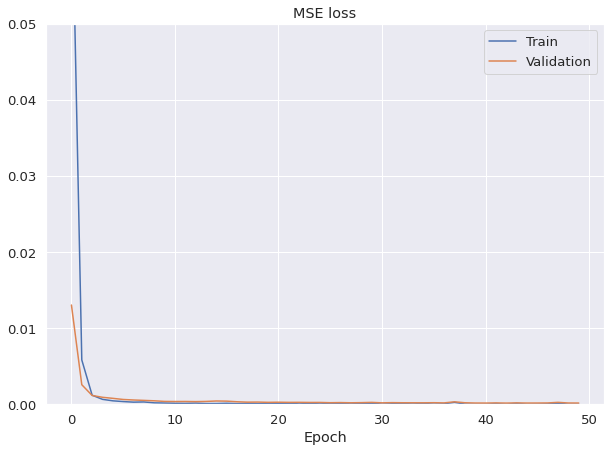

In [29]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(trainig_losses)), trainig_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.ylim(0, 0.05)
plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

## Детекция аномалий

Как мы уже говорили раньше, мы будем детектировать аномалии на основании того, насколько хорошо сеть воссоздает исходную последовательность. Более подробно


1.   Посчитаем MAE на трейне.
2.   Найдем максимум MAE на трейне. Это будет нашим порогом (`threshold`) для детекции (мы считаем, что на трейне аномалий нет)
3.   Если лосс больше `threshold`, то скорее всего у нас встретился паттерн, который автоэнкодер не видел при обучении. Будем считать его аномалией


In [32]:
X_loader = DataLoader(X, batch_size = 1)
model.eval()
threshold = 0
x_pred = []

with torch.no_grad():
    for batch in X_loader:
        pred = model(batch.to(device)).cpu().numpy()
        x_pred.append(pred.ravel())
        mae_loss = np.mean(np.abs(pred - batch.numpy()))
        if mae_loss > threshold:
            threshold = mae_loss
print("threshold = ", threshold)

threshold =  0.007881476


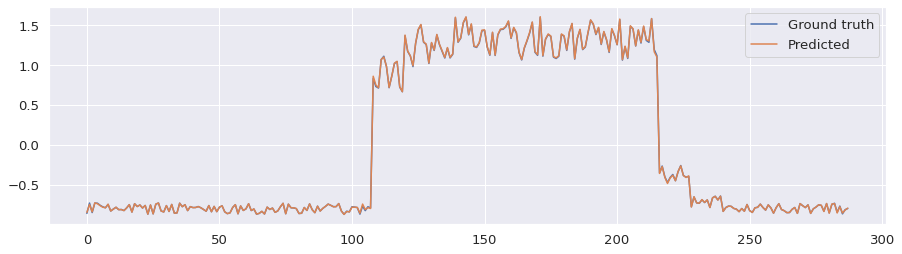

In [33]:
# Checking how the first sequence is learnt
plt.figure(figsize=(15, 4))
plt.plot(x_train[0].numpy().ravel(), label='Ground truth')
plt.plot(x_pred[0], label='Predicted')

plt.legend()
plt.show()

### Детекция на тестовых данных

Проделаем все, о чем мы говорили раньше:

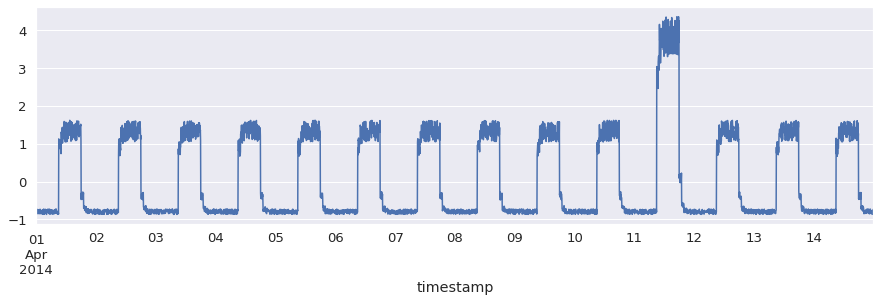

Test input shape:  torch.Size([3744, 1, 288])


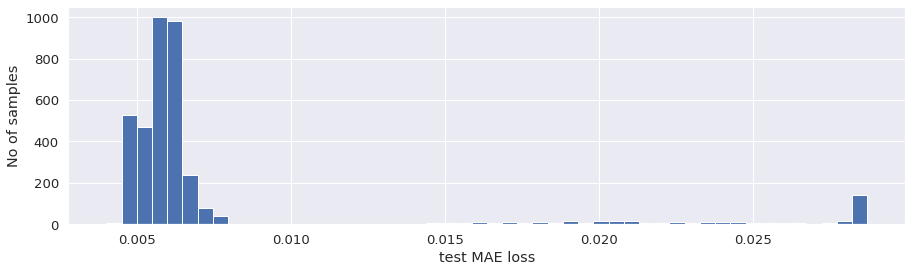

Number of anomaly samples:  399
Indices of anomaly samples:  (array([2509, 2512, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709,
       2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720,
       2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731,
       2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742,
       2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753,
       2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764,
       2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775,
       2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786,
       2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797,
       2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808,
       2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819,
       2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830,
       2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2

In [34]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots(figsize=(15, 4))
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
test_loader = torch.utils.data.DataLoader(x_test, shuffle=False)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.

test_losses = []
with torch.no_grad():
  for batch in test_loader:
    pred = model(batch.to(device)).cpu().numpy()
    mae_loss = np.mean(np.abs(pred - batch.numpy()))
    test_losses.append(mae_loss)

test_losses = np.array(test_losses).reshape((-1))

plt.figure(figsize=(15, 4))
plt.hist(test_losses, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_losses > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

## Графики аномалий

Теперь мы хотим найти аномальные `timestamps` из теста. Будем делать так:

Пусть к примеру `time_steps = 3` и в нашей выборке 10 значений. Наш `x_train` будет выглядеть так:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

Все значения, кроме начального и последних `time_steps - 1`, появятся в данных
`time_steps` number of samples.  Поэтому, если мы знаем, что последовательности
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] – это аномалии, мы можем сказать, что аномалия произошла в момент времени 5

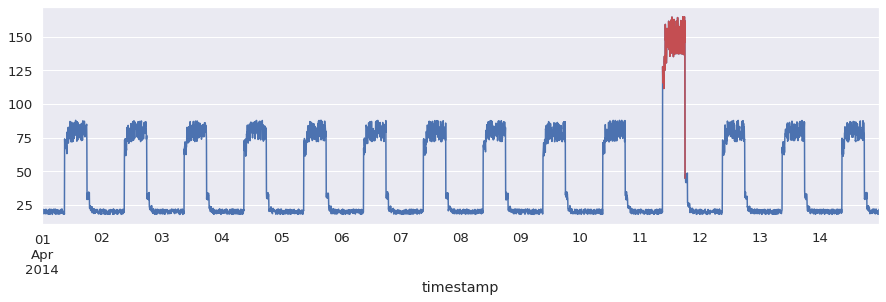

In [35]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)


df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots(figsize=(15, 4))
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()